In [1]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [2]:
!nvidia-smi

Sun Apr 21 16:41:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 35%   37C    P8             14W /  170W |    1326MiB /  12288MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Pollen DETR from Hugging Face Hub

In [15]:
import torch
import supervision as sv
import transformers
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor, pipeline
import re
import os
import glob
import random
import cv2
import numpy as np
import json
import pandas as pd
import shutil
import os
import torchvision
from torch.utils.data import DataLoader
import random
from label_studio_sdk import Client
from PIL import Image
import sys
sys.path.append('../')
# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'Charliesgt/pollencounter_detr_resnet50' # '_benchmark'
CONFIDENCE_TRESHOLD = 0.92
IOU_TRESHOLD = 0.5
INFERENCE_DIRECTORY = '../data/raw/ku_pollen/Videos/'
OUTPUT_DIRECTORY='../data/output/videos/'
pipeline_model = pipeline("object-detection", model=CHECKPOINT, device_map="auto")

In [16]:

from services.inference.video_processor import VideoProcessor

vp = VideoProcessor(
    pipeline_model=pipeline_model,
    source_video_path=f"{INFERENCE_DIRECTORY}2020-09-15 100x Video scan 1.mp4",
    target_video_path=OUTPUT_DIRECTORY,
    confidence_threshold=CONFIDENCE_TRESHOLD,
)
vp.process_video(start_offset=100, frames_to_generate=100, export_types=['video','annotations'])

frames = vp.result_frames
detection_results = vp.detections_manager.annotations
counts = vp.detections_manager.trackers

In [17]:
len(counts[0])

45

In [18]:
detection_results[19]

Detections(xyxy=array([[220.13692, 853.7165 , 276.60364, 906.5681 ],
       [747.0768 , 850.49615, 797.51416, 897.9644 ],
       [550.208  , 865.33203, 592.44336, 903.6617 ],
       [126.03289, 865.8557 , 177.98146, 914.8616 ]], dtype=float32), mask=None, confidence=array([0.98918587, 0.9752905 , 0.9434675 , 0.96929574], dtype=float32), class_id=array([0, 0, 0, 0]), tracker_id=array([13, 15, 19, 21]), data={})

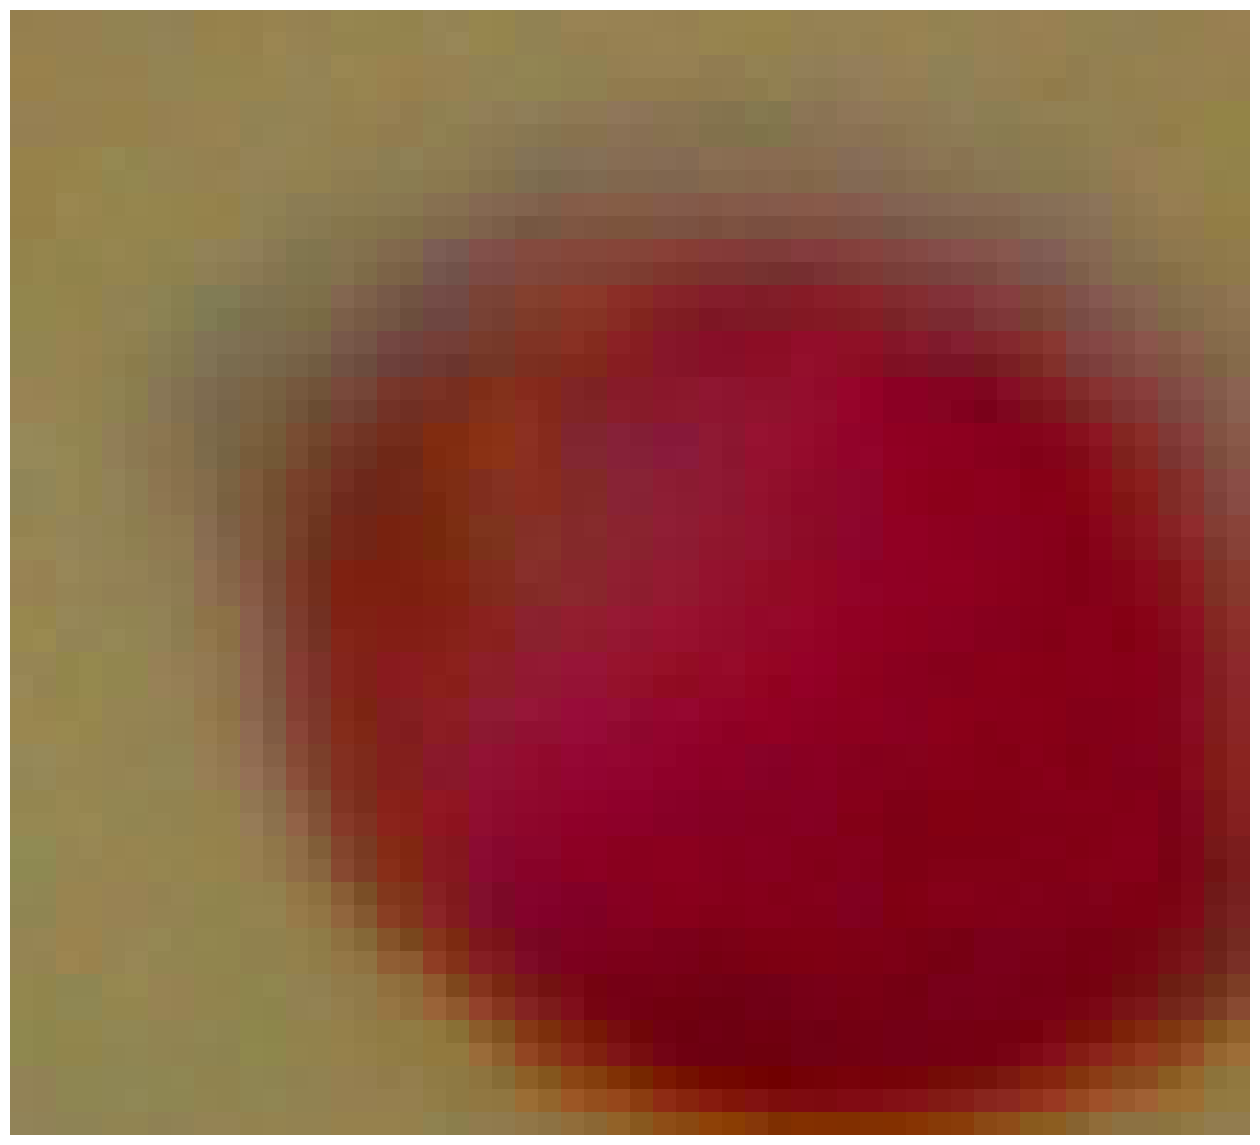

In [5]:
sv.plot_image(detection_results[2]['detection'], (16, 16))

## Handle Video Inference

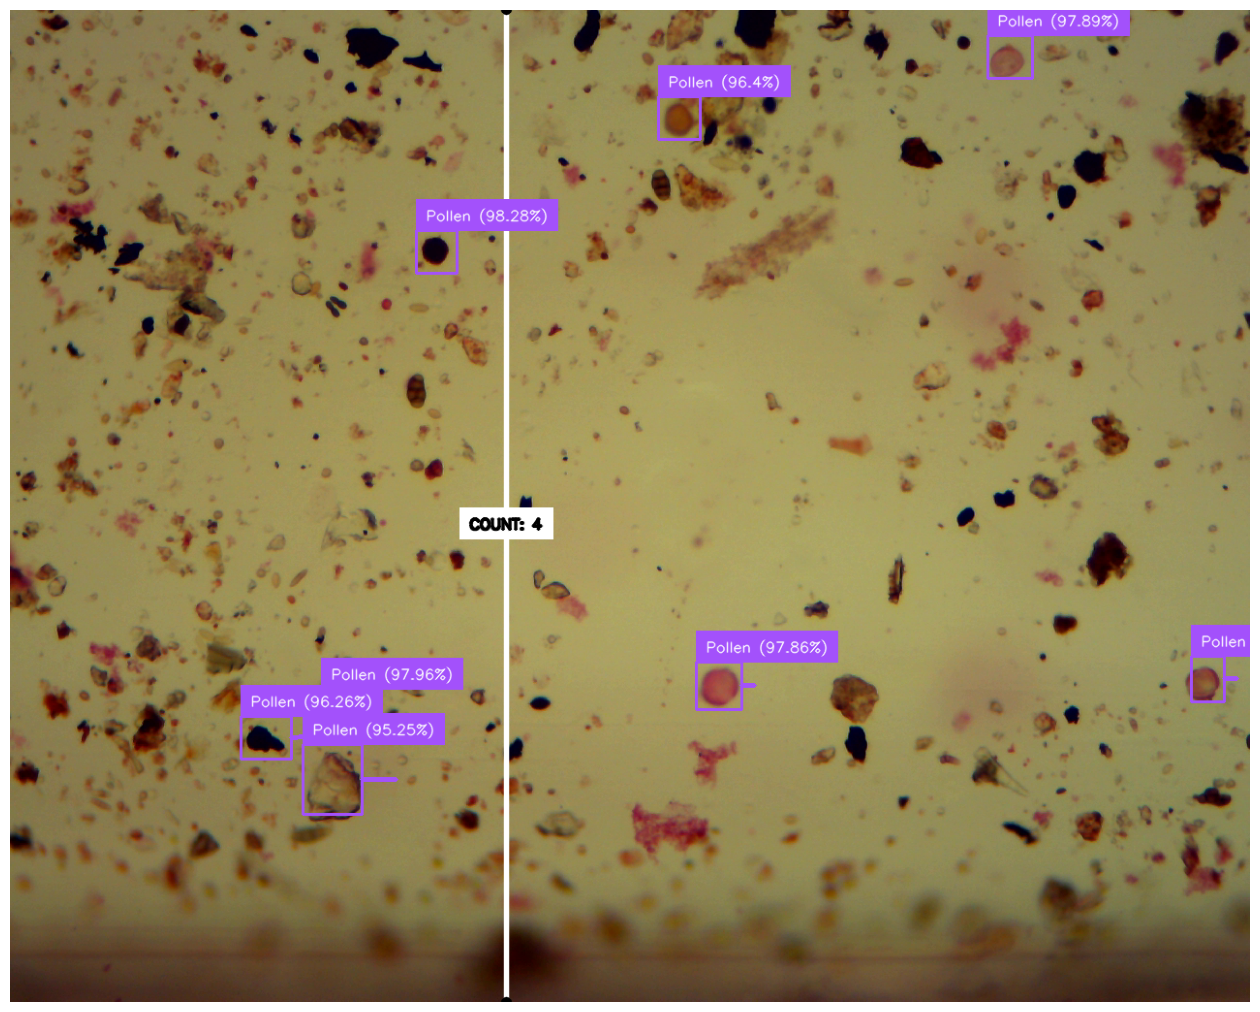

In [59]:
source_video_info = sv.VideoInfo.from_video_path(video_path=f"{INFERENCE_DIRECTORY}2020-09-15 100x Video scan 1.mp4")
prediction_threshold=0.91
stride = 1
start_offset = 100
frames_to_generate = 50

# Tracking
tracker = sv.ByteTrack(
    lost_track_buffer = 5,
    frame_rate=source_video_info.fps,
    minimum_matching_threshold=0.8
)
tracker.reset()
# Tracing and Zone Detection
LINE_START = sv.Point(int(source_video_info.width * 0.4), 0)
LINE_END = sv.Point(int(source_video_info.width * 0.4), source_video_info.height)
trace_annotator = sv.TraceAnnotator(
    thickness=3,
    trace_length=source_video_info.fps * 2,
    position=sv.Position.CENTER_RIGHT,
)
line_counter = sv.LineZone(start=LINE_START, end=LINE_END, triggering_anchors=[sv.Position.CENTER_RIGHT])
line_annotator = sv.LineZoneAnnotator(
    thickness=3,
    text_thickness=2,
    text_scale=0.5,
    #custom_in_text='IN',
    custom_out_text='COUNT',
    display_in_count=False,
    display_out_count=True
)

# Detection Labeling
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

frame_generator = sv.get_video_frames_generator(f"{INFERENCE_DIRECTORY}2020-09-15 100x Video scan 1.mp4",  stride=stride, start=start_offset, end=start_offset+frames_to_generate)
for frame in frame_generator:
    results = pipeline_model(Image.fromarray(frame), threshold=prediction_threshold)
    transformed_results = {
        'boxes':[],
        'scores':[],
        'labels':[]
    }
    for result in results:
        transformed_results['boxes'].append(np.array([result['box']['xmin'],result['box']['ymin'],result['box']['xmax'],result['box']['ymax']]))
        transformed_results['scores'].append(result['score'])
        transformed_results['labels'].append(0)
    detections = sv.Detections(
        xyxy=np.array(transformed_results['boxes']),
        confidence=np.array(transformed_results['scores']),
        class_id=np.array(transformed_results['labels']),
    )
    detections = detections.with_nms(threshold=0.5, class_agnostic=False)
    detections = tracker.update_with_detections(detections)
    crossed_in, crossed_out = line_counter.trigger(detections=detections)

    ## Annotate
    labels = [
        f"Pollen ({round(confidence*100,2)}%)"
        for class_id, tracker_id, confidence
        in zip(detections.class_id, detections.tracker_id, detections.confidence)
    ]
    annotated_frame = line_annotator.annotate(frame=frame.copy(), line_counter=line_counter)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

sv.plot_image(annotated_frame, (16, 16))

In [52]:
detections

Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int32), tracker_id=array([], dtype=int32), data={})

In [45]:
def predict_video(source_name, source_dir, target_dir, start_offset=0, frames_to_generate=-1, stride=-1, prediction_threshold=0.4):
    '''
    Issues right now are with the object trackers. They are double and triple counting objects and make the actual prediction solution inaccurate.
    
    
    '''
    source_video_info = sv.VideoInfo.from_video_path(video_path=f"{source_dir}{source_name}")
    if frames_to_generate <=0:
        frames_to_generate = source_video_info.total_frames - start_offset
    if stride <=0:
        stride = 1

    LINE_START = sv.Point(50, 0)
    LINE_END = sv.Point(50, source_video_info.height)

    tracker = sv.ByteTrack(track_activation_threshold=0.2,lost_track_buffer =5,frame_rate=source_video_info.fps, minimum_matching_threshold=0.8)
    tracker.reset()
    line_counter = sv.LineZone(start=LINE_START, end=LINE_END)
    line_annotator = sv.LineZoneAnnotator(
        thickness=3,
        text_thickness=2,
        text_scale=0.5,
        custom_in_text='IN',
        custom_out_text='OUT'
    )
    trace_annotator = sv.TraceAnnotator(
        thickness=3,
        trace_length=source_video_info.fps * 2,
        position=sv.Position.BOTTOM_CENTER,
    )
    box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    temp, file_ext = source_name.split('.')
    output_image_name = temp.replace(' ','_') + '.'+ file_ext

    def callback(frame: np.ndarray, _: int) -> np.ndarray:
        print('Handling Frame...')
        results = pipeline_model(Image.fromarray(frame), threshold=prediction_threshold)
        transformed_results = {
            'boxes':[],
            'scores':[],
            'labels':[]
        }
        for result in results:
            transformed_results['boxes'].append(np.array([result['box']['xmin'],result['box']['ymin'],result['box']['xmax'],result['box']['ymax']]))
            transformed_results['scores'].append(result['score'])
            transformed_results['labels'].append(0)
        detections = sv.Detections(
            xyxy=np.array(transformed_results['boxes']),
            confidence=np.array(transformed_results['scores']),
            class_id=np.array(transformed_results['labels']),
        )
        
        detections = tracker.update_with_detections(detections)
        detections = detections.with_nms(threshold=0.5, class_agnostic=False)
        labels = [
            f"Pollen ({round(confidence*100,2)}%)"
            for class_id, tracker_id, confidence
            in zip(detections.class_id, detections.tracker_id, detections.confidence)
        ]

        annotated_frame = box_annotator.annotate(
            frame.copy(), detections=detections)
        annotated_frame = label_annotator.annotate(
            annotated_frame.copy(), detections=detections, labels=labels)
        crossed_in, crossed_out = line_counter.trigger(detections=detections)

        return line_annotator.annotate(frame=annotated_frame.copy(), line_counter=line_counter)

    with sv.VideoSink(target_path=f"{target_dir}{output_image_name}", video_info=source_video_info) as sink:
        for index, frame in enumerate(sv.get_video_frames_generator(source_path = f"{source_dir}{source_name}", stride=stride, start=start_offset, end=start_offset+frames_to_generate)):
            result_frame = callback(frame, index)
            sink.write_frame(frame=result_frame)
    return tracker, line_counter
tracker, line_counter = predict_video(source_name='2020-09-15 100x Video scan 1.mp4', source_dir=INFERENCE_DIRECTORY,target_dir=OUTPUT_DIRECTORY,stride=1, start_offset=100, frames_to_generate=20, prediction_threshold=0.92)

Handling Frame...
Handling Frame...


KeyboardInterrupt: 

In [43]:
line_counter.in_count

0

In [23]:
source_video_info = sv.VideoInfo.from_video_path(video_path=f"{INFERENCE_DIRECTORY}2020-09-15 100x Video scan 1.mp4")
source_video_info

VideoInfo(width=1280, height=1024, fps=14, total_frames=894)

## Handle Video -> Images Inference

In [5]:
def predict_images(source_name, source_dir, target_dir, start_offset=0, frames_to_generate=-1, fps=-1, prediction_threshold=0.4):
    '''
    Issues right now are with the object trackers. They are double and triple counting objects and make the actual prediction solution inaccurate.
    
    
    '''
    source_video_info = sv.VideoInfo.from_video_path(video_path=f"{source_dir}{source_name}")
    if frames_to_generate <=0:
        frames_to_generate = source_video_info.total_frames
    if fps <=0:
        fps = source_video_info.fps

    box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    temp, file_ext = source_name.split('.')
    output_image_name = temp.replace(' ','_')

    def callback(frame: np.ndarray, _: int) -> np.ndarray:
        print('Handling Frame...')
        results = pipeline_model(Image.fromarray(frame), threshold=prediction_threshold)
        transformed_results = {
            'boxes':[],
            'scores':[],
            'labels':[]
        }
        for result in results:
            transformed_results['boxes'].append(np.array([result['box']['xmin'],result['box']['ymin'],result['box']['xmax'],result['box']['ymax']]))
            transformed_results['scores'].append(result['score'])
            transformed_results['labels'].append(0)
        detections = sv.Detections(
            xyxy=np.array(transformed_results['boxes']),
            confidence=np.array(transformed_results['scores']),
            class_id=np.array(transformed_results['labels']),
        )
        
        labels = [
            f"Pollen"
            for class_id
            in detections.class_id
        ]

        annotated_frame = box_annotator.annotate(frame.copy(), detections=detections)
        return label_annotator.annotate(annotated_frame, detections=detections, labels=labels)

    with sv.ImageSink(target_dir_path=f"{target_dir}{output_image_name}", overwrite=True) as sink:
        for index, frame in enumerate(sv.get_video_frames_generator(source_path = f"{source_dir}{source_name}", stride=fps, start=start_offset, end=start_offset+frames_to_generate)):
            result_frame = callback(frame, index)
            sink.save_image(result_frame, image_name=f'{index}.jpg')

predict_images(source_name='2020-09-15 100x Video scan 1.mp4', source_dir=INFERENCE_DIRECTORY,target_dir=OUTPUT_DIRECTORY,fps=30, start_offset=70, frames_to_generate=210, prediction_threshold=0.9)

Handling Frame...
Handling Frame...
Handling Frame...
Handling Frame...
Handling Frame...
Handling Frame...
Handling Frame...


## Handle Video -> Images for Training

In [1]:
import supervision as sv
def collect_images(source_name, source_dir, target_dir, start_offset=0, frames_to_generate=-1, fps=-1):
    source_video_info = sv.VideoInfo.from_video_path(video_path=f"{source_dir}{source_name}")
    if frames_to_generate <=0:
        frames_to_generate = source_video_info.total_frames
    if fps <=0:
        fps = source_video_info.fps

    temp, file_ext = source_name.split('.')
    output_image_name = temp.replace(' ','_')

    with sv.ImageSink(target_dir_path=f"{target_dir}{output_image_name}", overwrite=True) as sink:
        for index, frame in enumerate(sv.get_video_frames_generator(source_path = f"{source_dir}{source_name}", stride=fps, start=start_offset, end=start_offset+frames_to_generate)):
            sink.save_image(frame, image_name=f'FRAME_{index}_{output_image_name}.jpg')

collect_images(source_name='2020-09-15 100x Video scan 1.mp4', source_dir='../data/raw/ku_pollen/Videos/', target_dir='../data/raw/ku_pollen/ImagesFromVideos/', fps=28)